In [70]:
from src.TimeSeries import TimeSeries
from src.TimeSeriesPlot import TimeSeriesPlot
import yfinance as yf
from src.LSTMsPrediction import LSTMForecaster
import pandas as pd
import random
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Descargar cotizaciones de MELI (Mercado Libre)
meli = yf.download('MELI', start='2022-01-01', interval='1wk')
dates = meli.index
meli_prices = meli['Close']['MELI']

[*********************100%***********************]  1 of 1 completed


In [63]:
# Serie completa
ts_full_original = TimeSeries("$MELI original", dates, meli_prices)
ts_full = TimeSeries("$MELI original", dates, meli_prices).detrend_with_regression_fitting(1).detrend_with_regression_fitting(1)
trend = ts_full_original.tendency_with_regression_fitting(1)

# Serie recortada
index_until_2025 = len(dates[dates.year < 2025])
dates_until_2025 = dates[:index_until_2025]
ts_until_2025 = TimeSeries("$MELI original", dates_until_2025, ts_full.values[:index_until_2025])

In [43]:
SEED = 13
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [44]:
# Inicializar forecaster sobre recortada
learning_rate = 0.002
look_back = 10
batch_size = 8
epochs = 200
test_size = 0.2

models = {}
model_configs = {
    'model_1':{
        'hidden_sizes': [50],
        'dropout': 0.0,
    },
    'model_2':{
        'hidden_sizes': [50, 25],
        'dropout': 0.2,
    },
    'model_3':{
        'hidden_sizes': [75],
        'dropout': 0.0,
    },
    'model_4':{
        'hidden_sizes': [75, 50],
        'dropout': 0.2,
    },
    'model_5':{
        'hidden_sizes': [25, 50, 25],
        'dropout': 0.2,
    },
}

for model_name, config in model_configs.items():
    forecaster = LSTMForecaster(ts_until_2025, look_back=look_back, test_size=test_size, batch_size=batch_size)
    forecaster.init_model(input_size=1, **config, output_size=1)
    print(f'{model_name} training:')
    forecaster.train(epochs=epochs, lr=learning_rate)
    print('\n')
    models[model_name] = forecaster

model_1 training:
Epoch 20/200 - Loss: 0.041903
Epoch 40/200 - Loss: 0.036109
Epoch 60/200 - Loss: 0.032928
Epoch 80/200 - Loss: 0.030259
Epoch 100/200 - Loss: 0.025875
Epoch 120/200 - Loss: 0.021644
Epoch 140/200 - Loss: 0.018980
Epoch 160/200 - Loss: 0.015740
Epoch 180/200 - Loss: 0.012293
Epoch 200/200 - Loss: 0.009544


model_2 training:


/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 20/200 - Loss: 0.039597
Epoch 40/200 - Loss: 0.035187
Epoch 60/200 - Loss: 0.030307
Epoch 80/200 - Loss: 0.021575
Epoch 100/200 - Loss: 0.016096
Epoch 120/200 - Loss: 0.016044
Epoch 140/200 - Loss: 0.011565
Epoch 160/200 - Loss: 0.010232
Epoch 180/200 - Loss: 0.005306
Epoch 200/200 - Loss: 0.003037


model_3 training:
Epoch 20/200 - Loss: 0.041056
Epoch 40/200 - Loss: 0.033360
Epoch 60/200 - Loss: 0.026140
Epoch 80/200 - Loss: 0.022732
Epoch 100/200 - Loss: 0.020113
Epoch 120/200 - Loss: 0.015574
Epoch 140/200 - Loss: 0.013525
Epoch 160/200 - Loss: 0.009591
Epoch 180/200 - Loss: 0.010175
Epoch 200/200 - Loss: 0.007264


model_4 training:


/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 20/200 - Loss: 0.037788
Epoch 40/200 - Loss: 0.029386
Epoch 60/200 - Loss: 0.019752
Epoch 80/200 - Loss: 0.015439
Epoch 100/200 - Loss: 0.009071
Epoch 120/200 - Loss: 0.004566
Epoch 140/200 - Loss: 0.006121
Epoch 160/200 - Loss: 0.002112
Epoch 180/200 - Loss: 0.001743
Epoch 200/200 - Loss: 0.001267


model_5 training:


/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 20/200 - Loss: 0.047647
Epoch 40/200 - Loss: 0.033798
Epoch 60/200 - Loss: 0.027289
Epoch 80/200 - Loss: 0.021547
Epoch 100/200 - Loss: 0.011163
Epoch 120/200 - Loss: 0.007913
Epoch 140/200 - Loss: 0.007804
Epoch 160/200 - Loss: 0.006212
Epoch 180/200 - Loss: 0.001382
Epoch 200/200 - Loss: 0.001246




Test MSE: 13793.8477, Test MAE: 96.6067
Predicción MSE: 24274.7583, Predicción MAE: 117.3838


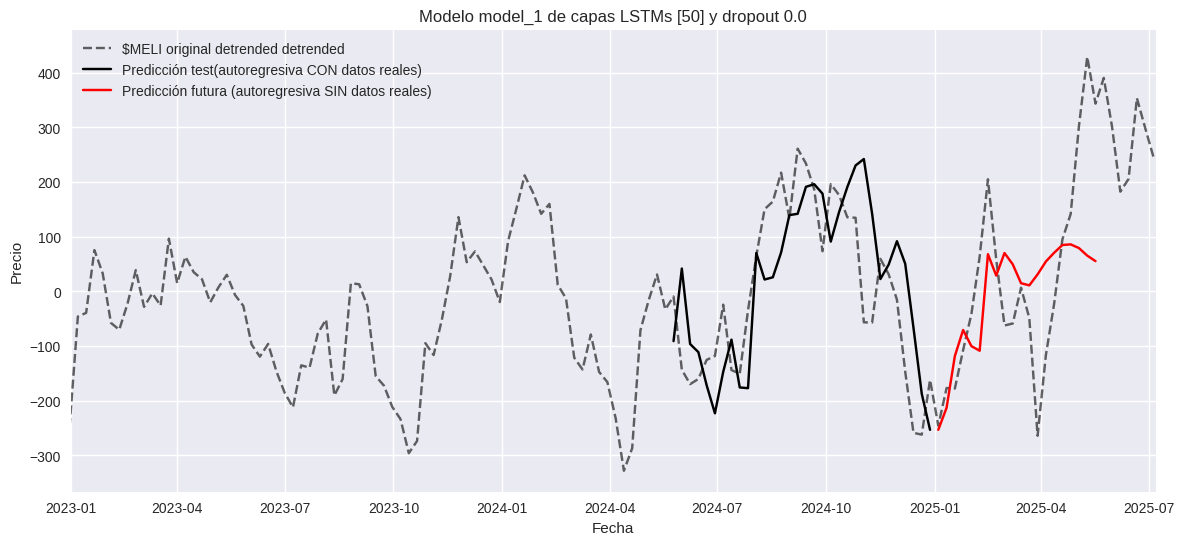

Test MSE: 11058.3749, Test MAE: 86.6990
Predicción MSE: 56651.5503, Predicción MAE: 172.6077


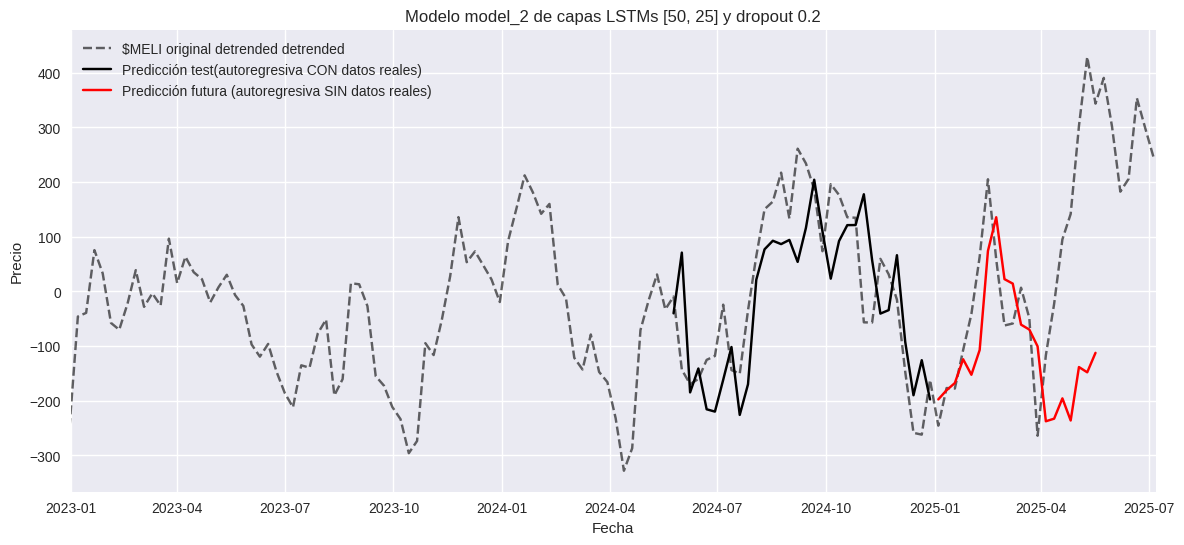

Test MSE: 13869.6395, Test MAE: 89.8670
Predicción MSE: 60757.5081, Predicción MAE: 165.0369


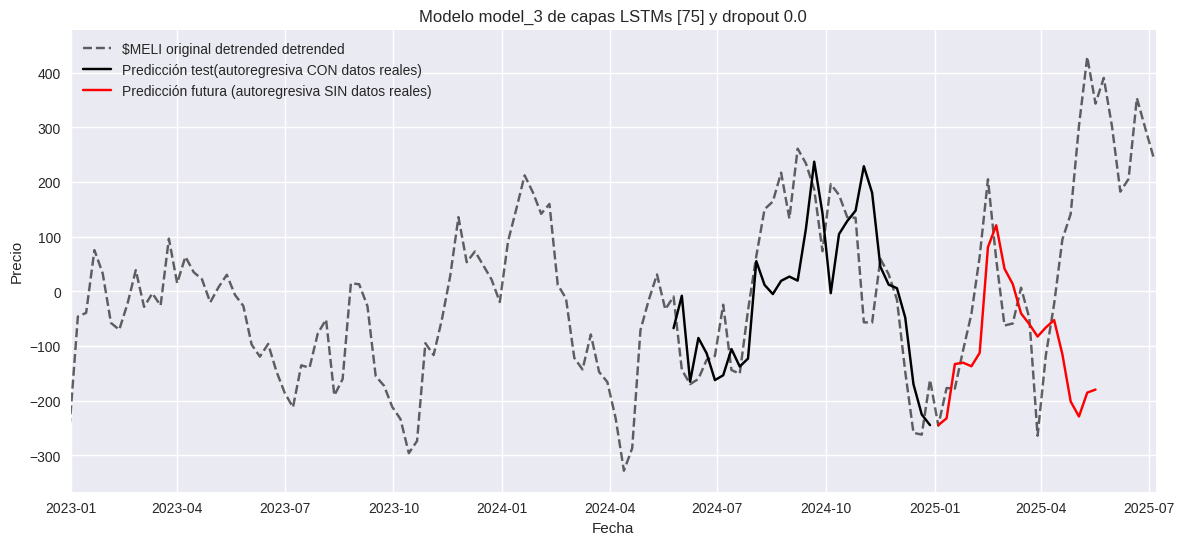

Test MSE: 15223.2875, Test MAE: 100.7054
Predicción MSE: 60974.0513, Predicción MAE: 177.2178


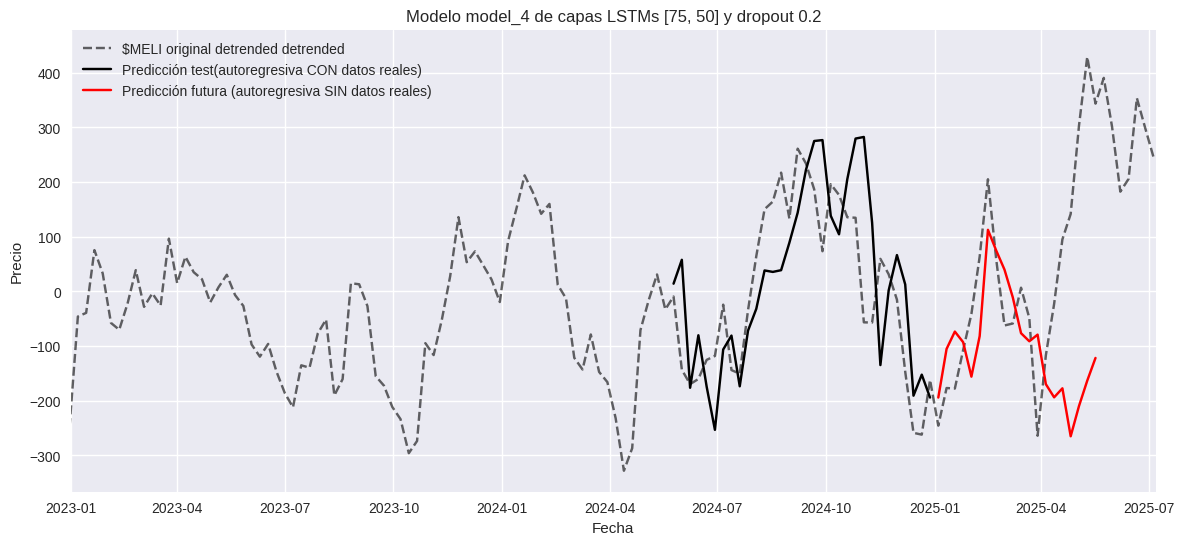

Test MSE: 14792.2226, Test MAE: 103.4600
Predicción MSE: 23520.0167, Predicción MAE: 113.5806


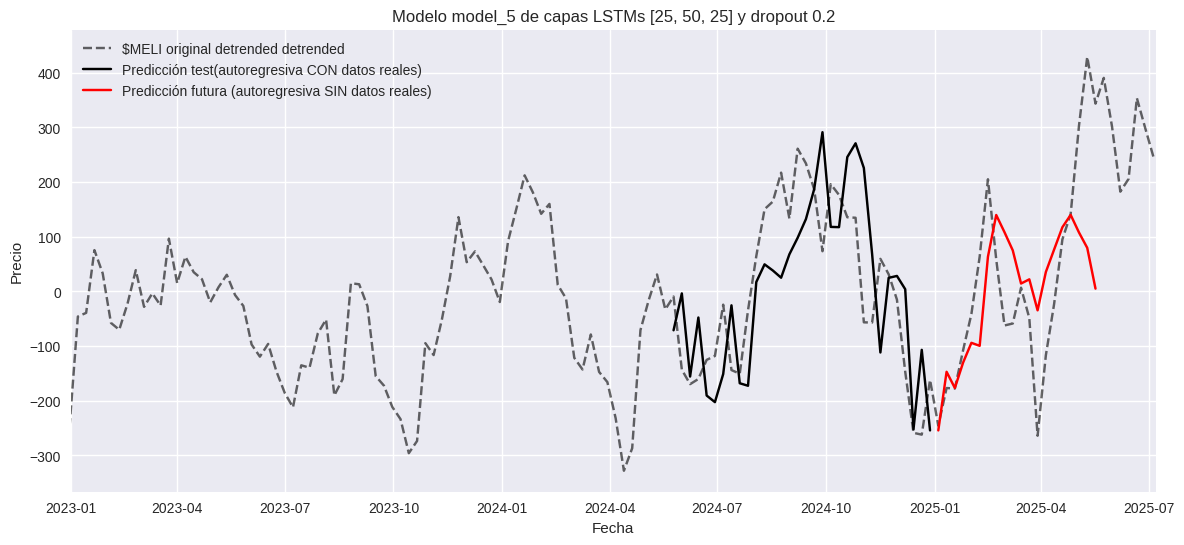

In [71]:
# Fechas para tramo de test
dates_test = dates_until_2025[int(len(dates_until_2025) * (1-test_size)):]

# Fechas para prediccion futura
n_steps = 20
dates_future_pred = dates[index_until_2025:index_until_2025+n_steps]

# Datos reales de prediccion futura
actual_future = ts_full.values[index_until_2025:index_until_2025+n_steps]

for model_name, model in models.items():
    # Prediccion test, ya printea MSE y MAE
    predictions, _ = model.evaluate()
    ts_pred = TimeSeries(f"Predicción test(autoregresiva CON datos reales)", dates_test, predictions)
    # Prediccion futura
    future_predictions = model.forecast_future(steps=n_steps)
    ts_future = TimeSeries(f"Predicción futura (autoregresiva SIN datos reales)", dates_future_pred, future_predictions)
    mse = mean_squared_error(actual_future, future_predictions)
    mae = mean_absolute_error(actual_future, future_predictions)
    print(f"Predicción MSE: {mse:.4f}, Predicción MAE: {mae:.4f}")
    # Plot
    plot = TimeSeriesPlot(ts_full)
    plot.set_title(f'Modelo {model_name} de capas LSTMs {model_configs[model_name]["hidden_sizes"]} y dropout {model_configs[model_name]["dropout"]}')
    plot.add_original(alpha=0.6, color='black', linestyle='--')
    plot.add_another(ts_pred, color='black')
    plot.add_another(ts_future, color="red")
    plot.set_lims(xlim=(pd.to_datetime('2023'),pd.to_datetime('2025-07-07')))
    plot.show()

Test MSE: 13793.8477, Test MAE: 96.6067
Predicción MSE: 24274.7583, Predicción MAE: 117.3838


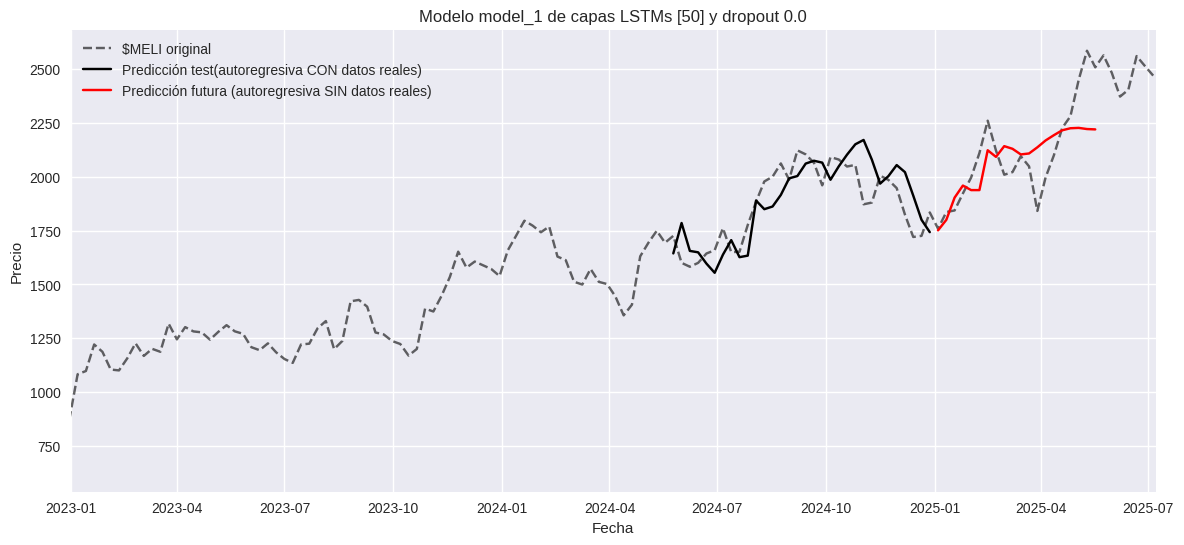

Test MSE: 11058.3749, Test MAE: 86.6990
Predicción MSE: 56651.5503, Predicción MAE: 172.6077


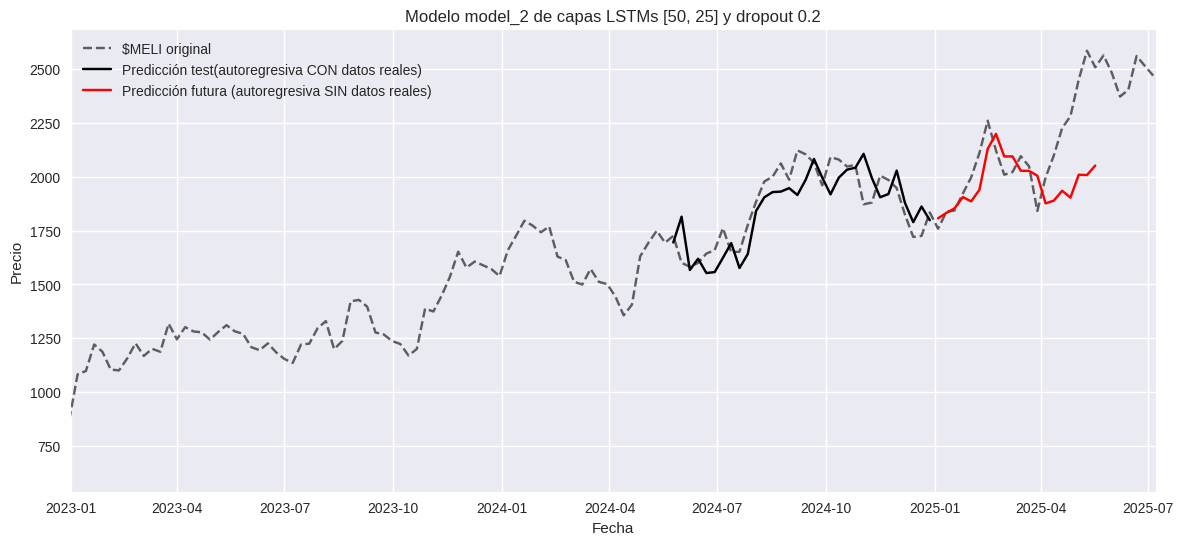

Test MSE: 13869.6395, Test MAE: 89.8670
Predicción MSE: 60757.5081, Predicción MAE: 165.0369


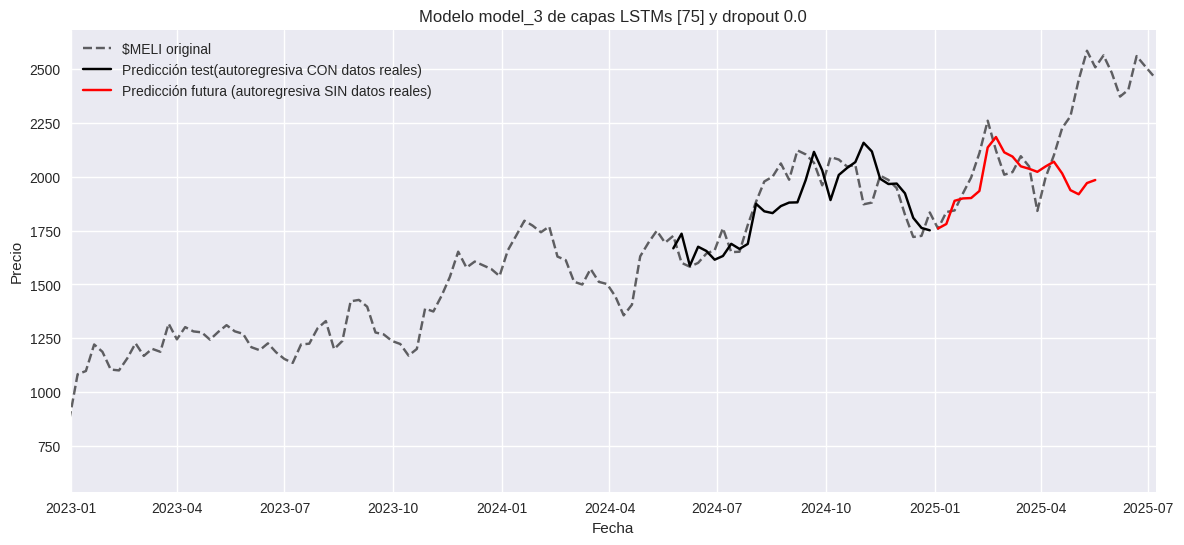

Test MSE: 15223.2875, Test MAE: 100.7054
Predicción MSE: 60974.0513, Predicción MAE: 177.2178


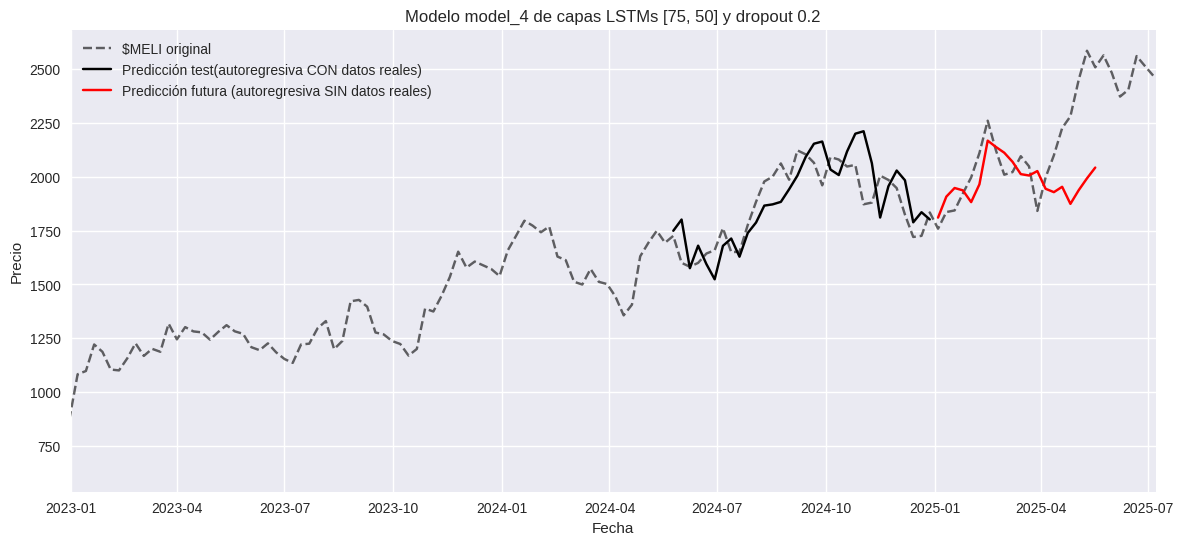

Test MSE: 14792.2226, Test MAE: 103.4600
Predicción MSE: 23520.0167, Predicción MAE: 113.5806


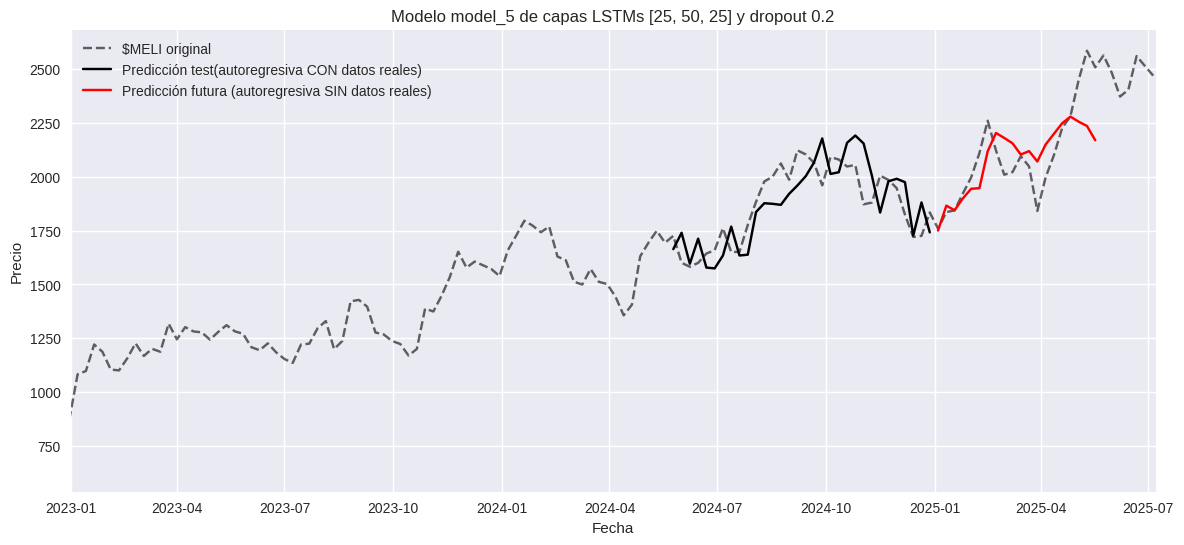

In [72]:
# Fechas para tramo de test
dates_test = dates_until_2025[int(len(dates_until_2025) * (1-test_size)):]

# Fechas para prediccion futura
n_steps = 20
dates_future_pred = dates[index_until_2025:index_until_2025+n_steps]

# Datos reales de prediccion futura
actual_future = ts_full_original.values[index_until_2025:index_until_2025+n_steps]

trend_future_pred = trend[index_until_2025:index_until_2025+n_steps]
trend_test = trend[int(len(dates_until_2025) * (1-test_size)):index_until_2025]

for model_name, model in models.items():
    # Prediccion test, ya printea MSE y MAE
    predictions, _ = model.evaluate()
    ts_test = TimeSeries(f"Predicción test(autoregresiva CON datos reales)", dates_test, predictions+trend_test)
    # Prediccion futura
    future_predictions = model.forecast_future(steps=n_steps)
    ts_future = TimeSeries(f"Predicción futura (autoregresiva SIN datos reales)", dates_future_pred, future_predictions+trend_future_pred)
    mse = mean_squared_error(actual_future, future_predictions+trend_future_pred)
    mae = mean_absolute_error(actual_future, future_predictions+trend_future_pred)
    print(f"Predicción MSE: {mse:.4f}, Predicción MAE: {mae:.4f}")
    # Plot
    plot = TimeSeriesPlot(ts_full_original)
    plot.set_title(f'Modelo {model_name} de capas LSTMs {model_configs[model_name]["hidden_sizes"]} y dropout {model_configs[model_name]["dropout"]}')
    plot.add_original(alpha=0.6, color='black', linestyle='--')
    plot.add_another(ts_test, color='black')
    plot.add_another(ts_future, color="red")
    plot.set_lims(xlim=(pd.to_datetime('2023'),pd.to_datetime('2025-07-07')))
    plot.show()

Ahora lo testeamos haciendo que prediga desde 2024-10, donde luego venía una caída. Si bien esto corresponde a la secuencia de test, hacemos una predicción autoregresiva sobre los mismos valores predichos, y sin utilizar los datos de test.
Nuevamente, predice de manera muy certera lo que sucederá desde ese punto: una caída de alrededor 250 puntos, para luego repuntar nuevamente, coincidiendo con el repunte real que ocurrio hacia 2025-02.

In [111]:
# Serie recortada
index_until_2025_04 = len(dates[dates < '2024-10-01'])
dates_until_2025_04 = dates[:index_until_2025_04]
ts_until_2025_04 = TimeSeries("$MELI original", dates_until_2025_04, ts_full.values[:index_until_2025_04])

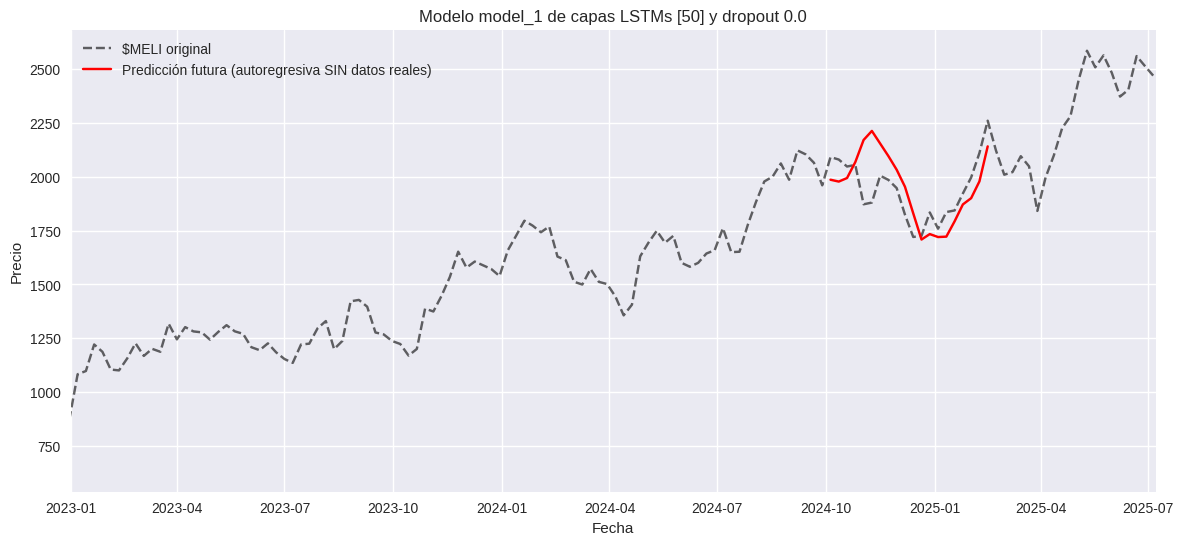

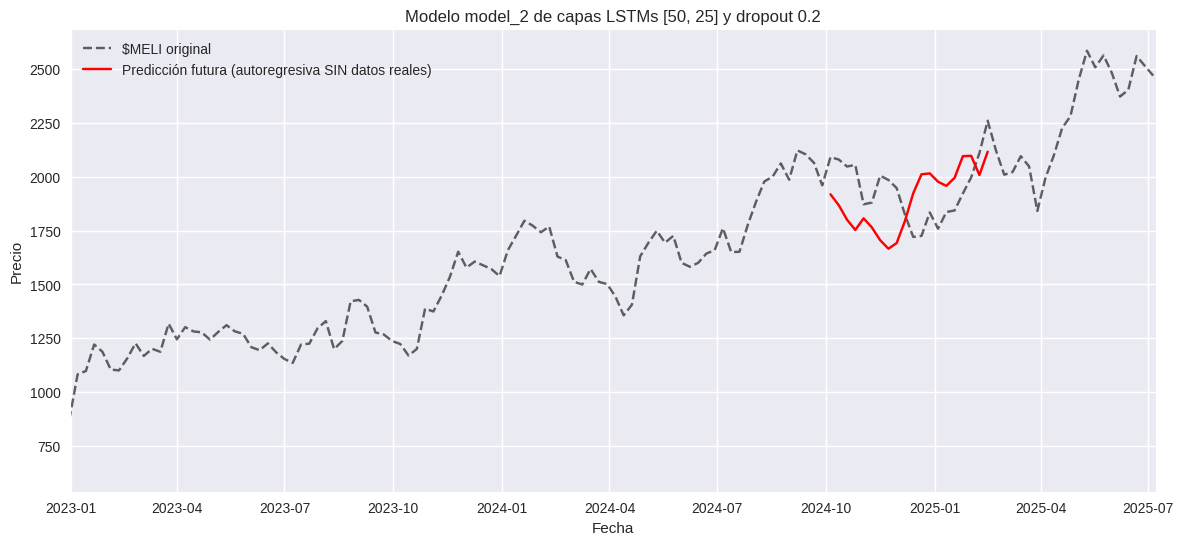

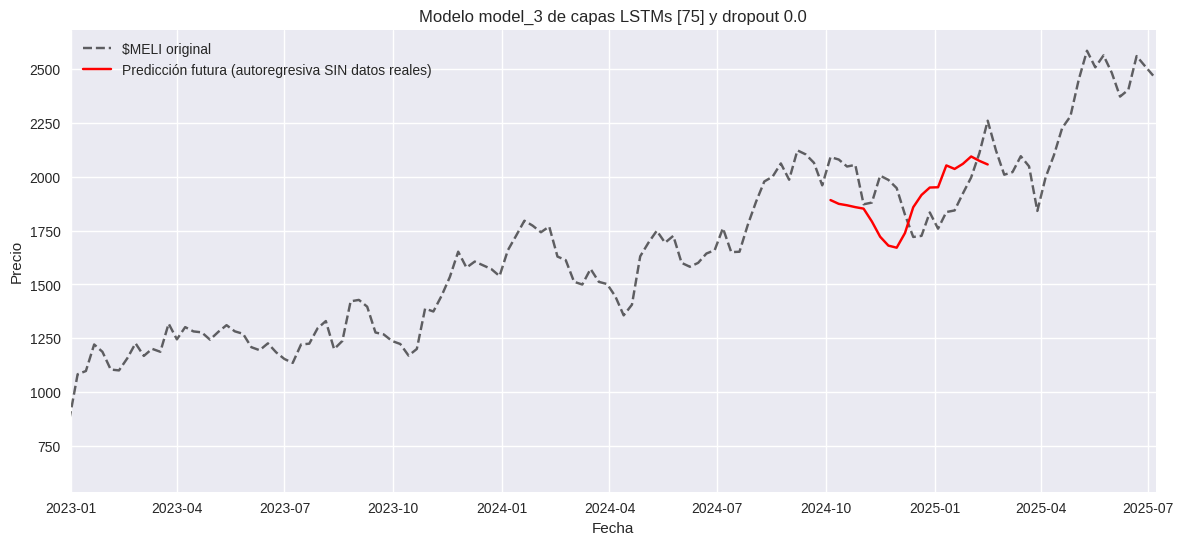

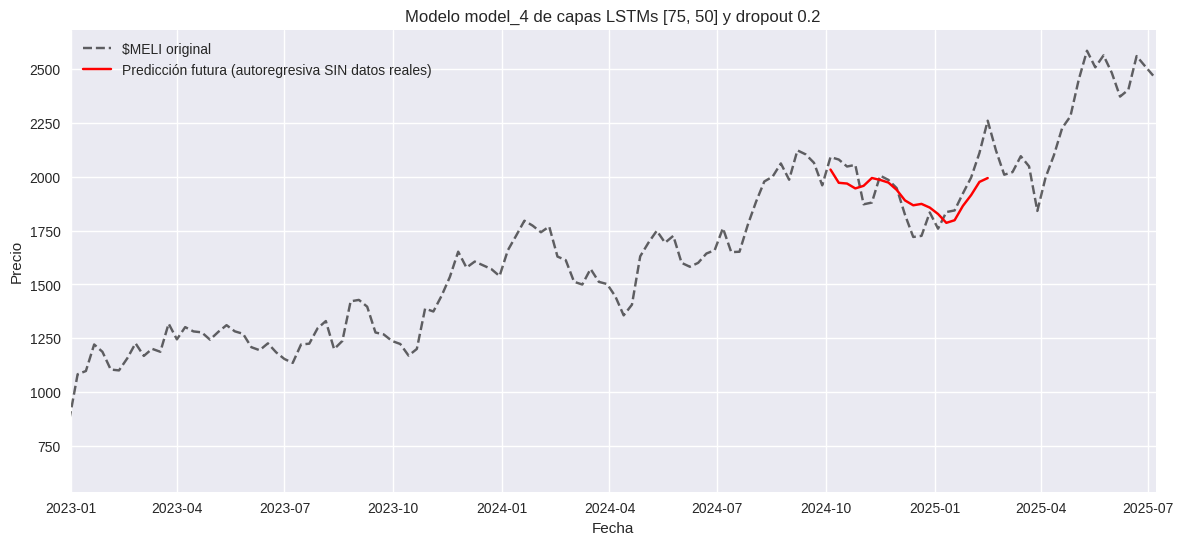

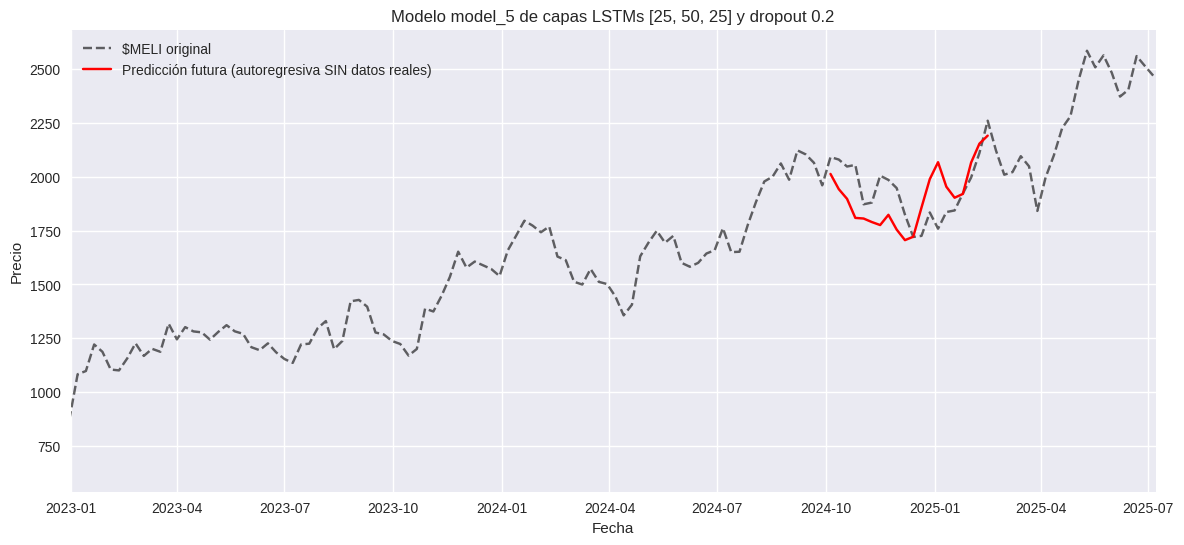

In [112]:
# Fechas para prediccion desde 2025-04
n_steps = 20
dates_future_pred_04 = dates[index_until_2025_04:index_until_2025_04+n_steps]
trend_future_pred = trend[index_until_2025_04:index_until_2025_04+n_steps]

for model_name, model in models.items():
    # Prediccion futura desde otro 2025-04
    future_predictions = model.forecast_from_input(input_sequence=ts_until_2025_04.values.values[-look_back:], steps=n_steps)
    ts_future = TimeSeries(f"Predicción futura (autoregresiva SIN datos reales)", dates_future_pred_04, future_predictions+trend_future_pred)
    #mse = mean_squared_error(actual_future, future_predictions+trend_future_pred)
    #mae = mean_absolute_error(actual_future, future_predictions+trend_future_pred)
    #print(f"Predicción MSE: {mse:.4f}, Predicción MAE: {mae:.4f}")
    # Plot
    plot = TimeSeriesPlot(ts_full_original)
    plot.set_title(f'Modelo {model_name} de capas LSTMs {model_configs[model_name]["hidden_sizes"]} y dropout {model_configs[model_name]["dropout"]}')
    plot.add_original(alpha=0.6, color='black', linestyle='--')
    #plot.add_another(ts_test, color='black')
    plot.add_another(ts_future, color="red")
    plot.set_lims(xlim=(pd.to_datetime('2023'),pd.to_datetime('2025-07-07')))
    plot.show()

In [115]:
for model_name, model in models.items():
    torch.save(model.model.state_dict(), f'../lstm_model_weights/{model_name}.pth')